In [2]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra

### Part 1: Get collocation points and integration kernel for whole domain

In [3]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$ and $p_{\rm eq}(x)$

In [4]:
sigma_kref = 8.
kref = get_k_by_sigma(sigma_kref)
Vref = harmonic_well_k_mean(xref, kref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq;

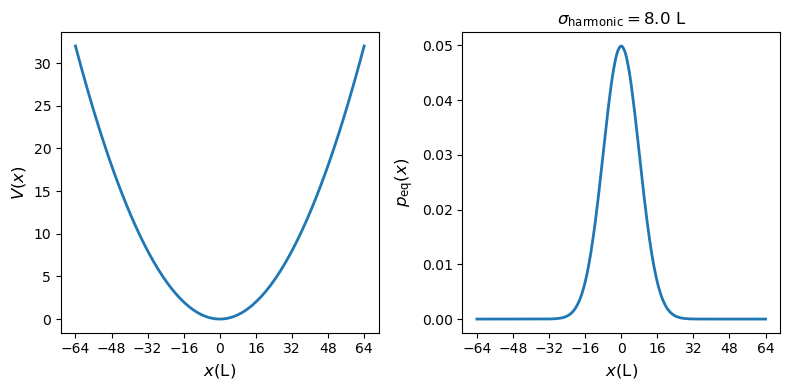

In [5]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, Vref, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
#ax.set_ylim(0, 10)

ax = axes[2]
ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
ax.set_title(@sprintf "\$\\sigma_{\\rm harmonic} = %.1f\$ L" sigma_kref)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/harmonic_well_r.svg")
plt.show()

### Part 3: Set parameters about simulations

In [6]:
# physical parameters
save_freq = 1e-2 # unit: s, Save trajectory per 1e-2 s
total_times = 100 # unit: s, totol simulate 100 s
dt = 2e-5 # unit: s  # Integration Times 1ps
D = 500; # Diffusion coefficient, unit: s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 500 timesteps. There will be 10000 data points.


In [7]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_well_r_0.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");

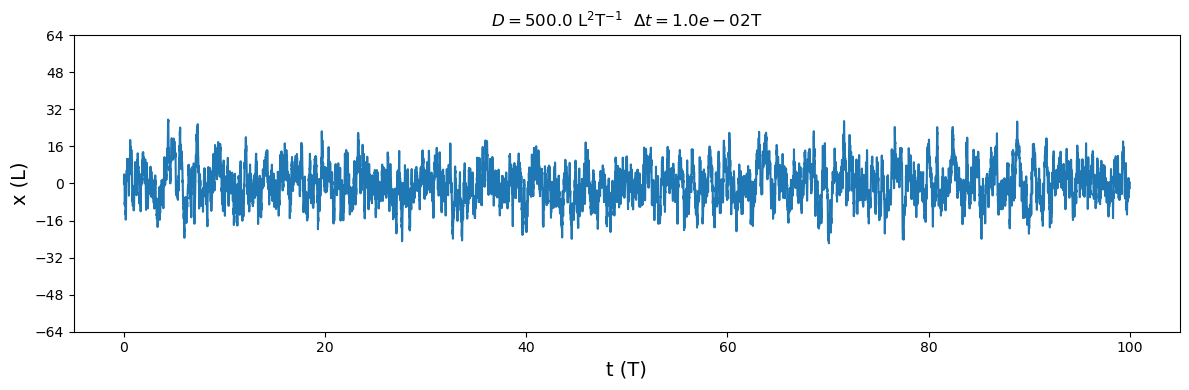

In [9]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

ax.plot(t_record, y_record)
ax.set_ylabel("x (L)", fontsize=lbfz)
ax.set_xlabel("t (T)", fontsize=lbfz)
ax.set_title(@sprintf "\$ D=%.1f\$ L\$^{2}\$T\$^{-1}\$  \$\\Delta t=%.1e\$T " D save_freq)
ax.set_yticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/reduced_traj.svg")
plt.show()

### Part 4: FEM to get eigenvector and eigenvalues

In [77]:
eigenvalues, eigenvect_mat, rho_eq_by_fem = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, p_eq, D, Nv)
weight_Qx = get_weight_Qx(N, Nv, w0, eigenvect_mat);

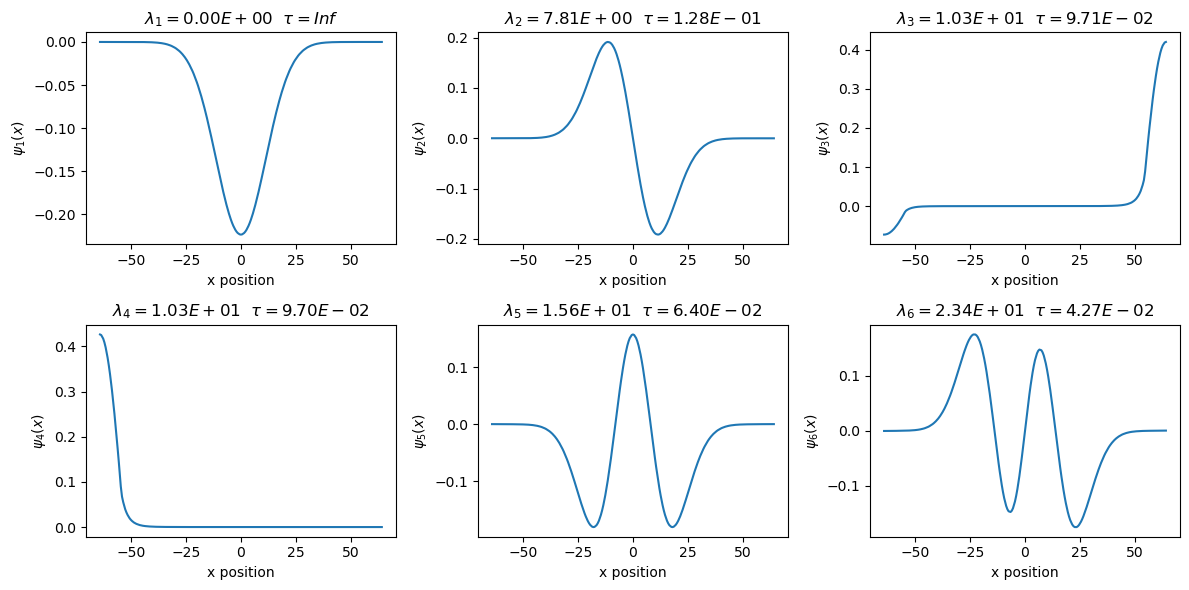

In [18]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12,6))

idx_eigvector = 1
for row_id = 1:2
    for col_id = 1:3
        plot_x_Qx_lambda(axes[row_id, col_id], idx_eigvector, eigenvalues, eigenvect_mat, xref)
        idx_eigvector += 1
        #axes[row_id, col_id].set_ylim(-0.4, 0.4)
    end
end

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/distance_dependent_D.pdf")
plt.show()

### Part 5: $p(x,0)$

In [207]:
σ_delta = 2.0 # 0.8
k_delta = get_k_by_sigma(σ_delta)
idx = find_nearest_point(y_record[1], xref, e_norm, interpo_xs, Np)
p_t0 = get_gaussian(k_delta, xref, idx)
p_t0 = p_t0 / sum(w0 .* p_t0);
sum(w0 .* p_t0)

1.0

In [208]:
alpha_t0_x = p_t0 ./ rho_eq
#alpha_t0_x = sqrt.(p_t0)
alpha_t0 = transpose(weight_Qx) * alpha_t0_x
alpha_t0_norm = norm(alpha_t0);
sum(alpha_t0_x .* rho_eq .* w0)

1.0

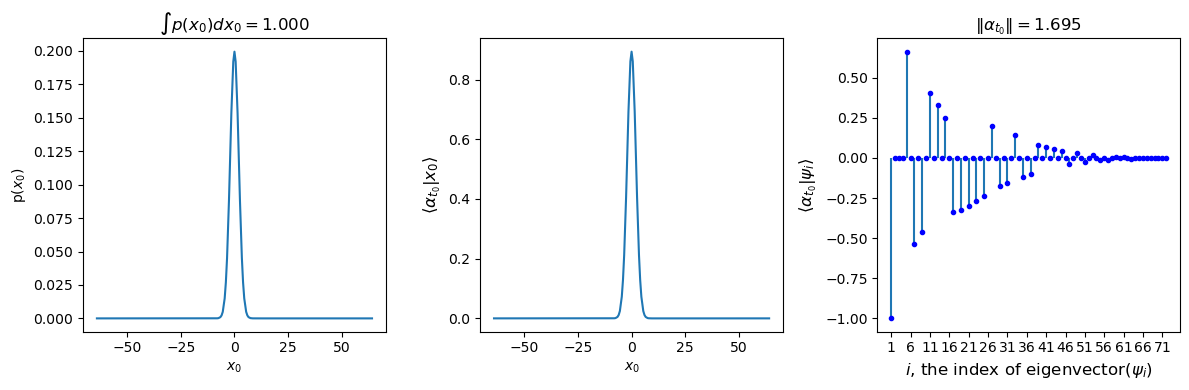

In [199]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_t0)
ax.set_ylabel("p(\$x_0\$)")
ax.set_xlabel("\$x_0\$")
title = @sprintf "\$ \\int p(x_0)dx_0=%.3f \$" sum(alpha_t0_x .* rho_eq .* w0)
ax.set_title(title)

ax = axes[2]
ax.plot(xref, alpha_t0_x)
ax.set_xlabel("\$x_0\$")
ax.set_ylabel("\$\\langle \\alpha_{t_0} | x_0 \\rangle\$", fontsize=12)

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t0, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t0)
ax.set_xticks(xticks)
ax.set_ylabel("\$\\langle \\alpha_{t_0} | \\psi_i \\rangle\$", fontsize=12)
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)", fontsize=12)
title = @sprintf "\$  \\Vert \\alpha_{t_0} \\Vert =%.3f \$" alpha_t0_norm
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/alpha_t0.pdf")
plt.show()

### Part 6: $\left< \hat{\alpha}_{t_{0}} \right| e^{-\textbf{H}\Delta t}$

In [209]:
expLQDT = exp.(-eigenvalues .* save_freq)
alpha_t0_e_delta_t = expLQDT .* alpha_t0;
alpha_t0_e_delta_t_norm = norm(alpha_t0_e_delta_t)
alpha_t0_e_delta_t_x = proj_vector_from_eigenspace_to_xspace(eigenvect_mat, alpha_t0_e_delta_t);
p_t0_e_delta_t = alpha_t0_e_delta_t_x .* rho_eq
sum(w0 .* p_t0_e_delta_t)

0.99997820885564

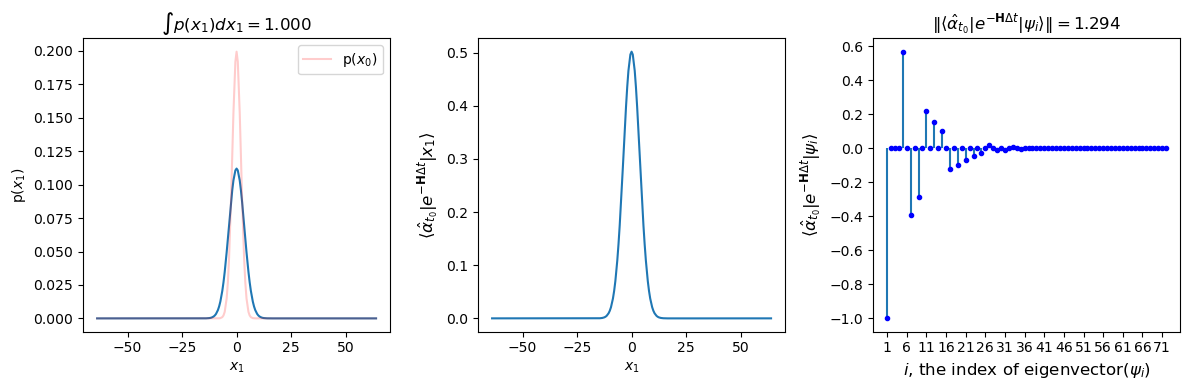

In [203]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_t0_e_delta_t)
ax.plot(xref, p_t0, alpha=0.2, color="red", label="p(\$x_0\$)")
ax.set_ylabel("p(\$x_1\$)")
ax.set_xlabel("\$x_1\$")
title = @sprintf "\$ \\int p(x_1)dx_1=%.3f \$" sum(w0 .* p_t0_e_delta_t)
ax.set_title(title)
ax.legend()

ax = axes[2]
ax.plot(xref, alpha_t0_e_delta_t_x)
ax.set_xlabel("\$x_1\$")
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_0} |e^{-\\mathbf{H}\\Delta t} |x_1 \\rangle\$", fontsize=12)

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t0_e_delta_t, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t0_e_delta_t)
ax.set_xticks(xticks)
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_0} | e^{-\\mathbf{H}\\Delta t}|\\psi_i \\rangle\$", fontsize=12)
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)", fontsize=12)
title = @sprintf "\$  \\Vert \\langle \\hat{\\alpha}_{t_0} | e^{-\\mathbf{H}\\Delta t}|\\psi_i \\rangle \\Vert =%.3f \$" alpha_t0_e_delta_t_norm
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/alpha_t0_e_dt.pdf")
plt.show()

Test $\sum_{i=2}^{N_v} \int  \left< \alpha_{t_0} | \psi_{i} \right>e^{-\lambda_{i} \Delta t}  \psi_{i}(x) dx = 0$

In [163]:
total_value = 0
for i=2:Nv
    total_value += sum(w0 .* alpha_t0_e_delta_t[i] .*  rho_eq .* eigenvect_mat[:, i])
end
total_value

-5.384903745370033e-12

### Part 7: $\left< \alpha_{t_1} \right| = \left< \hat{\alpha}_{t_{0}} \right| e^{-\textbf{H}\Delta t} \textbf{y}_1$

In [210]:
alpha_idx = 1
y = y_record[alpha_idx+1]
photon_mat = get_photon_matrix_gaussian(y, xref, e_norm, interpo_xs, Np, w0, k_delta)

# < alpha | exp(-H dt) y
psi_photon_psi = eigenvect_mat' * photon_mat * eigenvect_mat
alpha_t1 =  psi_photon_psi * alpha_t0_e_delta_t

alpha_t1_norm = norm(alpha_t1)
alpha_t1_x = proj_vector_from_eigenspace_to_xspace(eigenvect_mat, alpha_t1)
p_alpha1 = alpha_t1_x .* rho_eq
sum(w0 .* p_alpha1)

0.04030970287466618

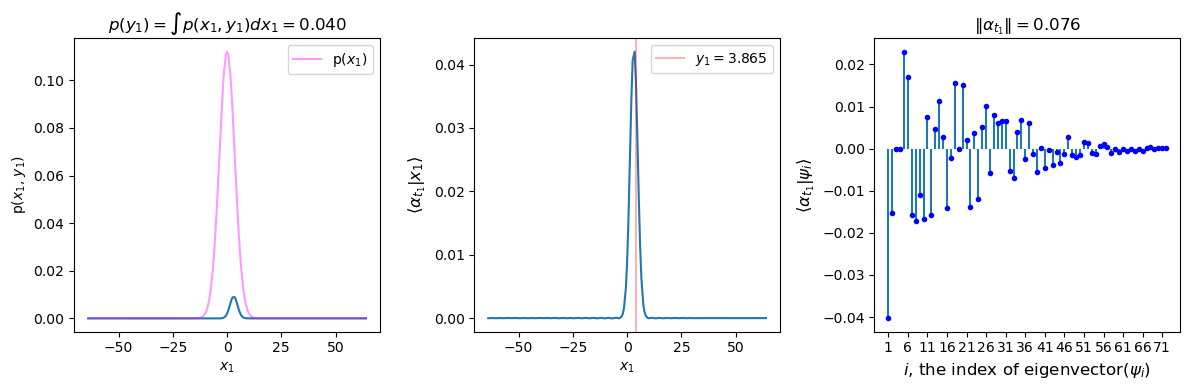

In [212]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_alpha1)
ax.plot(xref, p_t0_e_delta_t, alpha=0.4, color="magenta", label="p(\$x_1\$)")
ax.set_ylabel("p(\$x_1\$, \$y_1\$)")
ax.set_xlabel("\$x_1\$")
title = @sprintf "\$ p(y_1) = \\int p(x_1,y_1)dx_1=%.3f \$" sum(w0 .* p_alpha1)
ax.set_title(title)
ax.legend()

ax = axes[2]
ax.plot(xref, alpha_t1_x)
label = @sprintf "\$y_{%d}=%.3f\$" alpha_idx y
ax.axvline(y, color="red", alpha=0.3, label=label)
ax.set_xlabel("\$x_1\$")
ax.set_ylabel("\$\\langle \\alpha_{t_1} |x_1 \\rangle\$", fontsize=12)
ax.legend()

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t1, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t1)
ax.set_xticks(xticks)
ax.set_ylabel("\$\\langle \\alpha_{t_1}|\\psi_i \\rangle\$", fontsize=12)
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)", fontsize=12)
title = @sprintf "\$  \\Vert \\alpha_{t_1} \\Vert =%.3f \$" alpha_t1_norm
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/alpha_t1.pdf")
plt.show()

In [213]:
# Normalization
p_alpha1_hat = p_alpha1 / sum(w0 .* p_alpha1)

alpha_t1_hat_x = p_alpha1_hat ./ rho_eq
#alpha_t0_x = sqrt.(p_t0)
alpha_t1_hat = transpose(weight_Qx) * alpha_t1_hat_x
alpha_t1_hat_norm = norm(alpha_t1_hat)
sum(w0 .* p_alpha1_hat)

0.9999999999999996

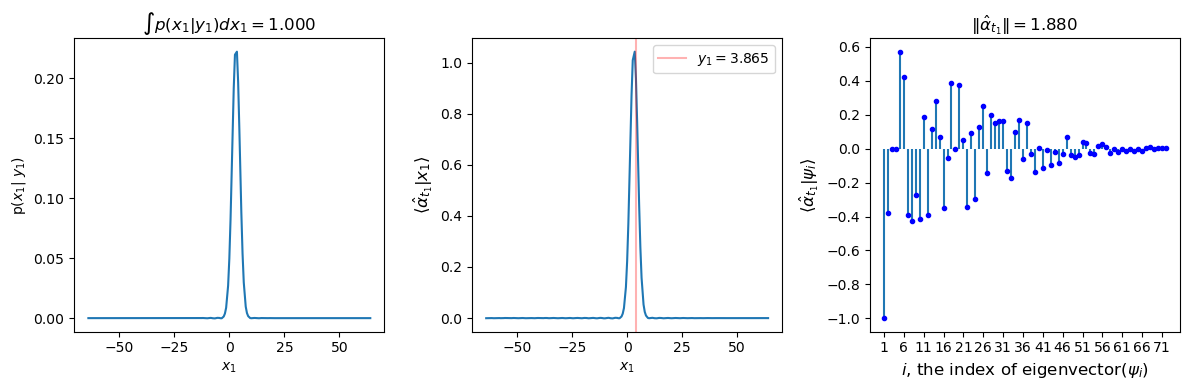

In [216]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_alpha1_hat)
ax.set_ylabel("p(\$x_1\$| \$y_1\$)")
ax.set_xlabel("\$x_1\$")
title = @sprintf "\$ \\int p(x_1| y_1)dx_1=%.3f \$" sum(w0 .* p_alpha1_hat)
ax.set_title(title)

ax = axes[2]
ax.plot(xref, alpha_t1_hat_x)
label = @sprintf "\$y_{%d}=%.3f\$" alpha_idx y
ax.axvline(y, color="red", alpha=0.3, label=label)
ax.set_xlabel("\$x_1\$")
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_1} |x_1 \\rangle\$", fontsize=12)
ax.legend()

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t1_hat, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t1_hat)
ax.set_xticks(xticks)
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_1} |\\psi_i \\rangle\$", fontsize=12)
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)", fontsize=12)
title = @sprintf "\$  \\Vert \\hat{\\alpha}_{t_1}  \\Vert =%.3f \$" alpha_t1_hat_norm
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/alpha_t1_hat.pdf")
plt.show()

### Part 8: $\left< \hat{\alpha}_{t_{1}} \right| e^{-\textbf{H}\Delta t}$

In [217]:
expLQDT = exp.(-eigenvalues .* save_freq)
alpha_t1_hat_e_delta_t = expLQDT .* alpha_t1_hat;
alpha_t1_hat_e_delta_t_norm = norm(alpha_t1_hat_e_delta_t)
alpha_t1_hat_e_delta_t_x = proj_vector_from_eigenspace_to_xspace(eigenvect_mat, alpha_t1_hat_e_delta_t)
p_t1_e_delta_t = alpha_t1_hat_e_delta_t_x .* rho_eq
sum(w0 .* p_t1_e_delta_t)

0.9999782088614485

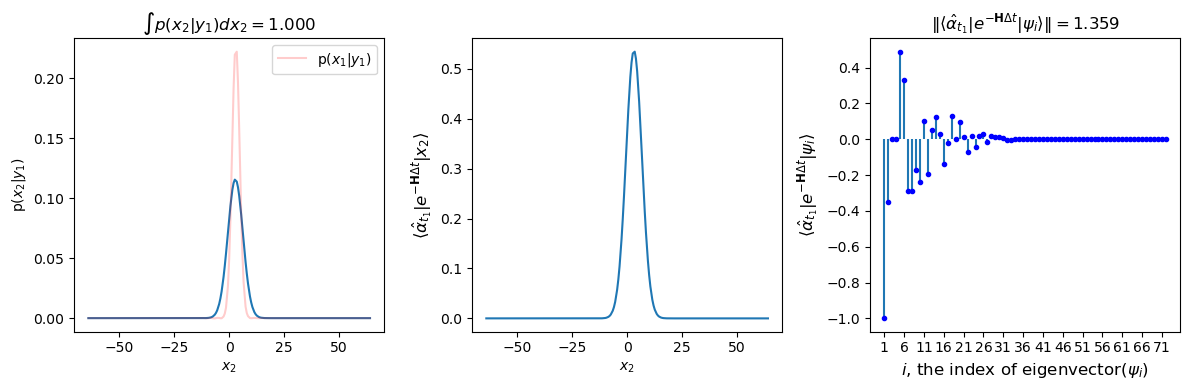

In [241]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_t1_e_delta_t)
ax.plot(xref, p_alpha1_hat, alpha=0.2, color="red", label="p(\$x_1\$|\$y_1\$)")
ax.set_ylabel("p(\$x_2\$|\$y_1\$)")
ax.set_xlabel("\$x_2\$")
title = @sprintf "\$ \\int p(x_2|y_1)dx_2=%.3f \$" sum(w0 .* p_t1_e_delta_t)
ax.set_title(title)
ax.legend()

ax = axes[2]
ax.plot(xref, alpha_t1_hat_e_delta_t_x)
ax.set_xlabel("\$x_2\$")
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_1} |e^{-\\mathbf{H}\\Delta t} |x_2 \\rangle\$", fontsize=12)

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t1_hat_e_delta_t, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t1_hat_e_delta_t)
ax.set_xticks(xticks)
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_1} | e^{-\\mathbf{H}\\Delta t}|\\psi_i \\rangle\$", fontsize=12)
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)", fontsize=12)
title = @sprintf "\$  \\Vert \\langle \\hat{\\alpha}_{t_1} | e^{-\\mathbf{H}\\Delta t}|\\psi_i \\rangle \\Vert =%.3f \$" alpha_t1_hat_e_delta_t_norm
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/alpha_t1_e_dt.pdf")
plt.show()

Test $\sum_{i=2}^{N_v} \int  \left< \hat{\alpha}_{t_1} | \psi_{i} \right>e^{-\lambda_{i} \Delta t}  \psi_{i}(x) dx = 0$

In [175]:
total_value = 0
for i=2:Nv
    total_value += sum(w0 .* alpha_t1_hat_e_delta_t_x[i] .*  rho_eq .* eigenvect_mat[:, i])
end
total_value

-1.0416476403017332e-12

### Part 9: $\left< \hat{\alpha}_{t_{1}} \right| e^{-\textbf{H}\Delta t} \textbf{y}_2$

In [224]:
alpha_idx = 2
y = y_record[alpha_idx+1]
photon_mat = get_photon_matrix_gaussian(y, xref, e_norm, interpo_xs, Np, w0, k_delta)

# < alpha | exp(-H dt) y
psi_photon_psi = eigenvect_mat' * photon_mat * eigenvect_mat
alpha_t1_hat_e_delta_t_y2 =  psi_photon_psi * alpha_t1_hat_e_delta_t

alpha_t1_hat_e_delta_t_y2_norm = norm(alpha_t1_hat_e_delta_t_y2)
alpha_t1_hat_e_delta_t_y2_x = proj_vector_from_eigenspace_to_xspace(eigenvect_mat, alpha_t1_hat_e_delta_t_y2)
p_alpha2 = alpha_t1_hat_e_delta_t_y2_x .* rho_eq
sum(w0 .* p_alpha2)

0.05204572314285977

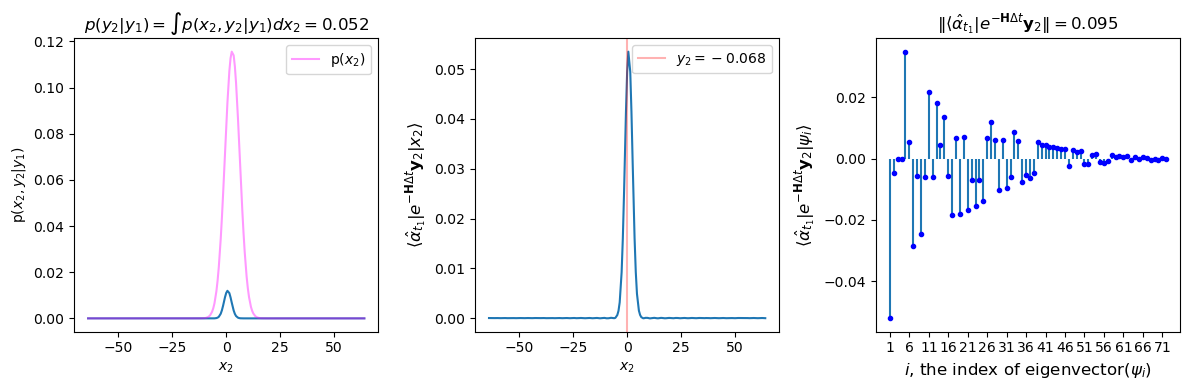

In [243]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_alpha2)
ax.plot(xref, p_t1_e_delta_t, alpha=0.4, color="magenta", label="p(\$x_2\$)")
ax.set_ylabel("p(\$x_2, y_2|y_1\$)")
ax.set_xlabel("\$x_2\$")
title = @sprintf "\$ p(y_2|y_1) = \\int p(x_2,y_2|y_1)dx_2=%.3f \$" sum(w0 .* p_alpha2)
ax.set_title(title)
ax.legend()

ax = axes[2]
ax.plot(xref, alpha_t1_hat_e_delta_t_y2_x)
label = @sprintf "\$y_{%d}=%.3f\$" alpha_idx y
ax.axvline(y, color="red", alpha=0.3, label=label)
ax.set_xlabel("\$x_2\$")
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_1}| e^{-\\mathbf{H}\\Delta t} \\mathbf{y}_2 |x_2 \\rangle\$", fontsize=12)
ax.legend()

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t1_hat_e_delta_t_y2, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t1_hat_e_delta_t_y2)
ax.set_xticks(xticks)
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_1}| e^{-\\mathbf{H}\\Delta t} \\mathbf{y}_2|\\psi_i \\rangle\$", fontsize=12)
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)", fontsize=12)
title = @sprintf "\$  \\Vert \\langle \\hat{\\alpha}_{t_1}| e^{-\\mathbf{H}\\Delta t} \\mathbf{y}_2 \\Vert =%.3f \$" alpha_t1_hat_e_delta_t_y2_norm
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/alpha_t1_hat_e_dt_y2.pdf")
plt.show()

### $\left< \hat{\alpha}_{t_{2}} \right|$

In [244]:
# Normalization
p_alpha2_hat = p_alpha2 / sum(w0 .* p_alpha2)

alpha_t2_hat_x = p_alpha2_hat ./ rho_eq
#alpha_t0_x = sqrt.(p_t0)
alpha_t2_hat = transpose(weight_Qx) * alpha_t2_hat_x
alpha_t2_hat_norm = norm(alpha_t2_hat)
sum(w0 .* p_alpha2_hat)

1.0000000000000002

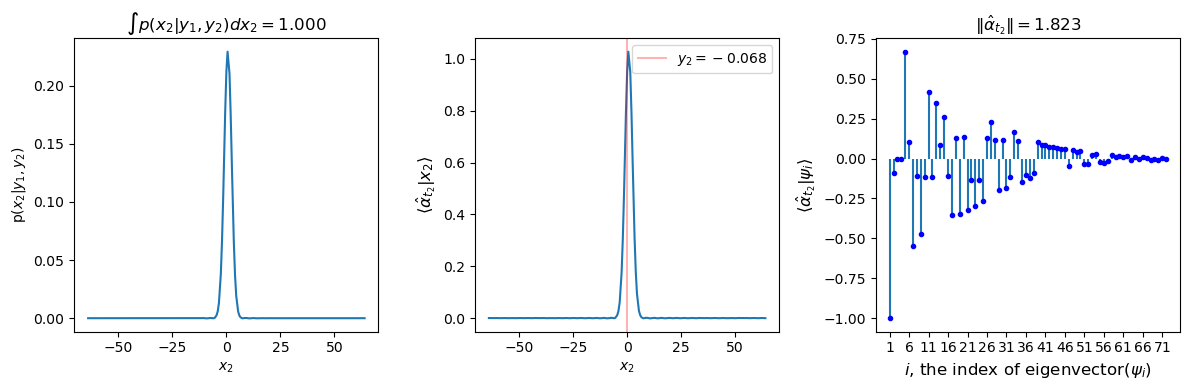

In [247]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_alpha2_hat)
ax.set_ylabel("p(\$x_2\$|\$y_1,y_2\$)")
ax.set_xlabel("\$x_2\$")
title = @sprintf "\$ \\int p(x_2| y_1,y_2)dx_2=%.3f \$" sum(w0 .* p_alpha2_hat)
ax.set_title(title)

ax = axes[2]
ax.plot(xref, alpha_t2_hat_x)
label = @sprintf "\$y_{%d}=%.3f\$" alpha_idx y
ax.axvline(y, color="red", alpha=0.3, label=label)
ax.set_xlabel("\$x_2\$")
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_2} |x_2 \\rangle\$", fontsize=12)
ax.legend()

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t2_hat, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t2_hat)
ax.set_xticks(xticks)
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_2} |\\psi_i \\rangle\$", fontsize=12)
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)", fontsize=12)
title = @sprintf "\$  \\Vert \\hat{\\alpha}_{t_2}  \\Vert =%.3f \$" alpha_t2_hat_norm
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/alpha_t2_hat.pdf")
plt.show()

### Part 10: $\left< \hat{\alpha}_{t_{2}} \right| e^{-\textbf{H}\Delta t}$

In [248]:
expLQDT = exp.(-eigenvalues .* save_freq)
alpha_t2_hat_e_delta_t = expLQDT .* alpha_t2_hat;
alpha_t2_hat_e_delta_t_norm = norm(alpha_t2_hat_e_delta_t)
alpha_t2_hat_e_delta_t_x = proj_vector_from_eigenspace_to_xspace(eigenvect_mat, alpha_t2_hat_e_delta_t)
p_t2_e_delta_t = alpha_t2_hat_e_delta_t_x .* rho_eq
sum(w0 .* p_t2_e_delta_t)

0.9999782088611697

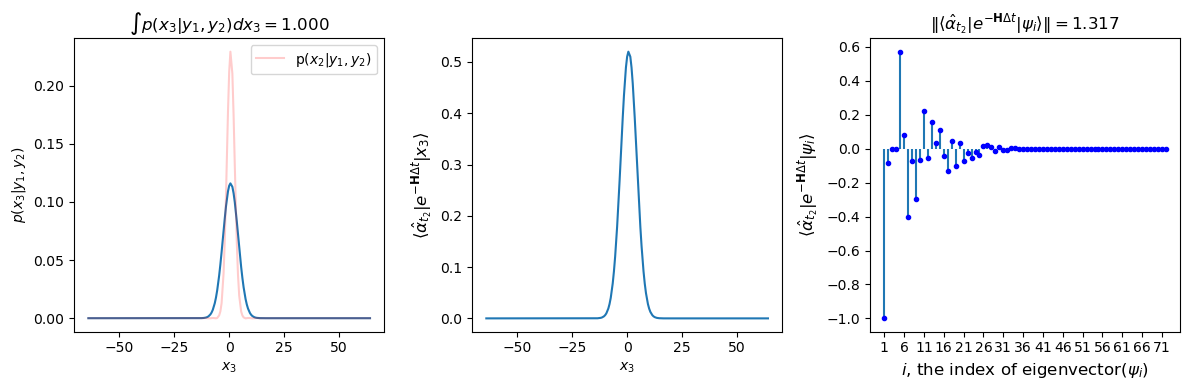

In [252]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_t2_e_delta_t)
ax.plot(xref, p_alpha2_hat, alpha=0.2, color="red", label="p(\$x_2\$|\$y_1,y_2\$)")
ax.set_ylabel("\$p(x_3|y_1,y_2)\$")
ax.set_xlabel("\$x_3\$")
title = @sprintf "\$ \\int p(x_3|y_1,y_2) dx_3=%.3f \$" sum(w0 .* p_t2_e_delta_t)
ax.set_title(title)
ax.legend()

ax = axes[2]
ax.plot(xref, alpha_t2_hat_e_delta_t_x)
ax.set_xlabel("\$x_3\$")
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_2} |e^{-\\mathbf{H}\\Delta t} |x_3 \\rangle\$", fontsize=12)

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t2_hat_e_delta_t, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t2_hat_e_delta_t)
ax.set_xticks(xticks)
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_2} | e^{-\\mathbf{H}\\Delta t}|\\psi_i \\rangle\$", fontsize=12)
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)", fontsize=12)
title = @sprintf "\$  \\Vert \\langle \\hat{\\alpha}_{t_2} | e^{-\\mathbf{H}\\Delta t}|\\psi_i \\rangle \\Vert =%.3f \$" alpha_t2_hat_e_delta_t_norm
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/alpha_t2_e_dt.pdf")
plt.show()

### Part 11: $\left< \hat{\alpha}_{t_{2}} \right| e^{-\textbf{H}\Delta t} \textbf{y}_3$

In [254]:
alpha_idx = 3
y = y_record[alpha_idx+1]
photon_mat = get_photon_matrix_gaussian(y, xref, e_norm, interpo_xs, Np, w0, k_delta)

# < alpha | exp(-H dt) y
psi_photon_psi = eigenvect_mat' * photon_mat * eigenvect_mat
alpha_t2_hat_e_delta_t_y3 =  psi_photon_psi * alpha_t2_hat_e_delta_t

alpha_t2_hat_e_delta_t_y3_norm = norm(alpha_t2_hat_e_delta_t_y3)
alpha_t2_hat_e_delta_t_y3_x = proj_vector_from_eigenspace_to_xspace(eigenvect_mat, alpha_t2_hat_e_delta_t_y3)
p_alpha3 = alpha_t2_hat_e_delta_t_y3_x .* rho_eq
sum(w0 .* p_alpha3)

0.046960324351023014

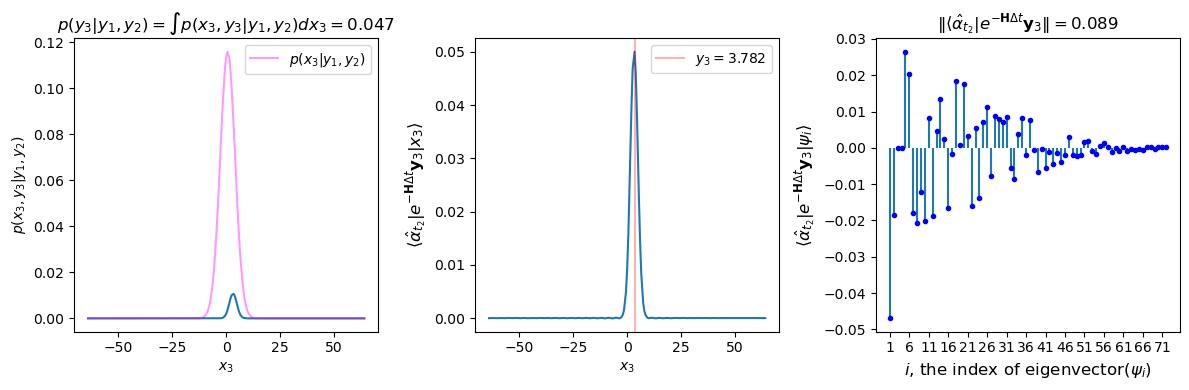

In [258]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_alpha3)
ax.plot(xref, p_t2_e_delta_t, alpha=0.4, color="magenta", label="\$p(x_3|y_1,y_2)\$")
ax.set_ylabel("\$p(x_3, y_3|y_1, y_2)\$")
ax.set_xlabel("\$x_3\$")
title = @sprintf "\$ p(y_3|y_1,y_2) = \\int p(x_3, y_3|y_1, y_2)dx_3=%.3f \$" sum(w0 .* p_alpha3)
ax.set_title(title)
ax.legend()

ax = axes[2]
ax.plot(xref, alpha_t2_hat_e_delta_t_y3_x)
label = @sprintf "\$y_{%d}=%.3f\$" alpha_idx y
ax.axvline(y, color="red", alpha=0.3, label=label)
ax.set_xlabel("\$x_3\$")
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_2}| e^{-\\mathbf{H}\\Delta t} \\mathbf{y}_3 |x_3 \\rangle\$", fontsize=12)
ax.legend()

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t2_hat_e_delta_t_y3, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t2_hat_e_delta_t_y3)
ax.set_xticks(xticks)
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_2}| e^{-\\mathbf{H}\\Delta t} \\mathbf{y}_3|\\psi_i \\rangle\$", fontsize=12)
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)", fontsize=12)
title = @sprintf "\$  \\Vert \\langle \\hat{\\alpha}_{t_2}| e^{-\\mathbf{H}\\Delta t} \\mathbf{y}_3 \\Vert =%.3f \$" alpha_t2_hat_e_delta_t_y3_norm
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/alpha_t2_hat_e_dt_y3.pdf")
plt.show()

### $\left< \hat{\alpha}_{t_{3}} \right|$

In [259]:
# Normalization
p_alpha3_hat = p_alpha3 / sum(w0 .* p_alpha3)

alpha_t3_hat_x = p_alpha3_hat ./ rho_eq
#alpha_t0_x = sqrt.(p_t0)
alpha_t3_hat = transpose(weight_Qx) * alpha_t3_hat_x
alpha_t3_hat_norm = norm(alpha_t3_hat)
sum(w0 .* p_alpha3_hat)

1.0

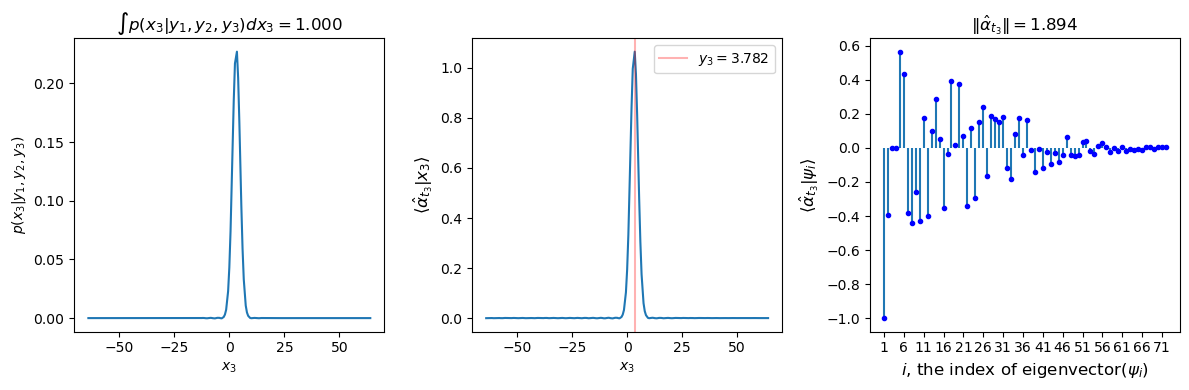

In [261]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_alpha3_hat)
ax.set_ylabel("\$p(x_3|y_1,y_2,y_3)\$")
ax.set_xlabel("\$x_3\$")
title = @sprintf "\$ \\int p(x_3|y_1,y_2,y_3)dx_3=%.3f \$" sum(w0 .* p_alpha3_hat)
ax.set_title(title)

ax = axes[2]
ax.plot(xref, alpha_t3_hat_x)
label = @sprintf "\$y_{%d}=%.3f\$" alpha_idx y
ax.axvline(y, color="red", alpha=0.3, label=label)
ax.set_xlabel("\$x_3\$")
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_3} |x_3 \\rangle\$", fontsize=12)
ax.legend()

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t3_hat, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t3_hat)
ax.set_xticks(xticks)
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_3} |\\psi_i \\rangle\$", fontsize=12)
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)", fontsize=12)
title = @sprintf "\$  \\Vert \\hat{\\alpha}_{t_3}  \\Vert =%.3f \$" alpha_t3_hat_norm
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/alpha_t3_hat.pdf")
plt.show()

### Part 12: $\left< \hat{\alpha}_{t_{3}} \right| e^{-\textbf{H}\Delta t}$

In [262]:
expLQDT = exp.(-eigenvalues .* save_freq)
alpha_t3_hat_e_delta_t = expLQDT .* alpha_t3_hat;
alpha_t3_hat_e_delta_t_norm = norm(alpha_t3_hat_e_delta_t)
alpha_t3_hat_e_delta_t_x = proj_vector_from_eigenspace_to_xspace(eigenvect_mat, alpha_t3_hat_e_delta_t)
p_t3_e_delta_t = alpha_t3_hat_e_delta_t_x .* rho_eq
sum(w0 .* p_t3_e_delta_t)

0.9999782088614639

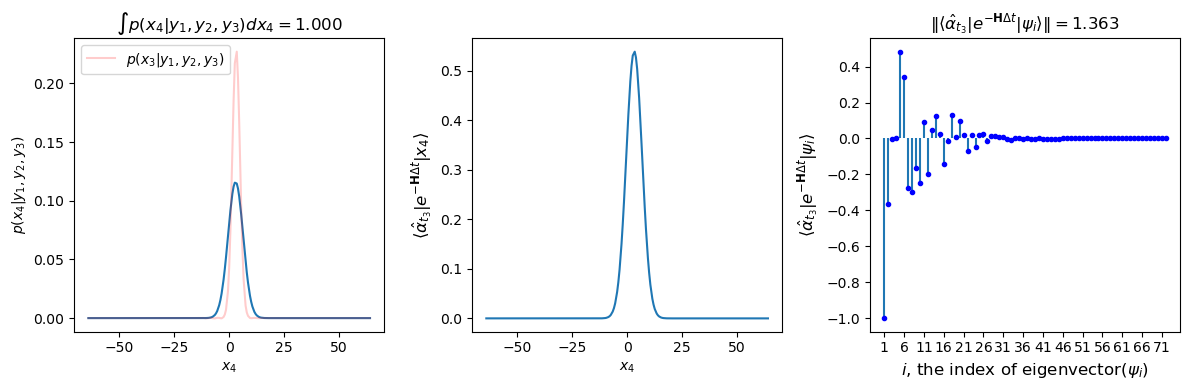

In [264]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_t3_e_delta_t)
ax.plot(xref, p_alpha3_hat, alpha=0.2, color="red", label="\$p(x_3|y_1,y_2,y_3)\$")
ax.set_ylabel("\$p(x_4|y_1,y_2,y_3)\$")
ax.set_xlabel("\$x_4\$")
title = @sprintf "\$ \\int p(x_4|y_1,y_2,y_3) dx_4=%.3f \$" sum(w0 .* p_t3_e_delta_t)
ax.set_title(title)
ax.legend()

ax = axes[2]
ax.plot(xref, alpha_t3_hat_e_delta_t_x)
ax.set_xlabel("\$x_4\$")
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_3} |e^{-\\mathbf{H}\\Delta t} |x_4 \\rangle\$", fontsize=12)

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t3_hat_e_delta_t, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t3_hat_e_delta_t)
ax.set_xticks(xticks)
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_3} | e^{-\\mathbf{H}\\Delta t}|\\psi_i \\rangle\$", fontsize=12)
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)", fontsize=12)
title = @sprintf "\$  \\Vert \\langle \\hat{\\alpha}_{t_3} | e^{-\\mathbf{H}\\Delta t}|\\psi_i \\rangle \\Vert =%.3f \$" alpha_t3_hat_e_delta_t_norm
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/alpha_t3_e_dt.pdf")
plt.show()

### Part 13: $\left< \hat{\alpha}_{t_{3}} \right| e^{-\textbf{H}\Delta t} \textbf{y}_4$

In [265]:
alpha_idx = 4
y = y_record[alpha_idx+1]
photon_mat = get_photon_matrix_gaussian(y, xref, e_norm, interpo_xs, Np, w0, k_delta)

# < alpha | exp(-H dt) y
psi_photon_psi = eigenvect_mat' * photon_mat * eigenvect_mat
alpha_t3_hat_e_delta_t_y4 =  psi_photon_psi * alpha_t3_hat_e_delta_t

alpha_t3_hat_e_delta_t_y4_norm = norm(alpha_t3_hat_e_delta_t_y4)
alpha_t3_hat_e_delta_t_y4_x = proj_vector_from_eigenspace_to_xspace(eigenvect_mat, alpha_t3_hat_e_delta_t_y4)
p_alpha4 = alpha_t3_hat_e_delta_t_y4_x .* rho_eq
sum(w0 .* p_alpha4)

0.05604296712798802

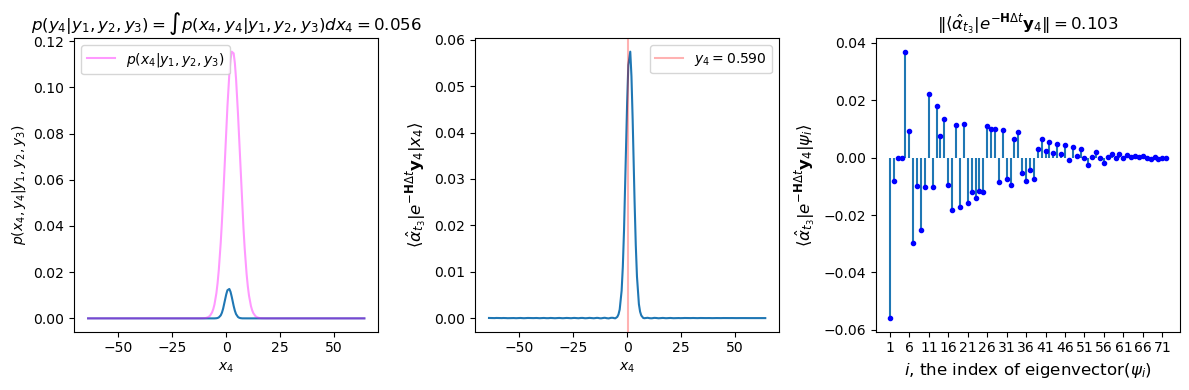

In [267]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_alpha4)
ax.plot(xref, p_t3_e_delta_t, alpha=0.4, color="magenta", label="\$p(x_4|y_1,y_2,y_3)\$")
ax.set_ylabel("\$p(x_4, y_4|y_1, y_2, y_3)\$")
ax.set_xlabel("\$x_4\$")
title = @sprintf "\$ p(y_4|y_1,y_2,y_3) = \\int p(x_4, y_4|y_1, y_2, y_3)dx_4=%.3f \$" sum(w0 .* p_alpha4)
ax.set_title(title)
ax.legend()

ax = axes[2]
ax.plot(xref, alpha_t3_hat_e_delta_t_y4_x)
label = @sprintf "\$y_{%d}=%.3f\$" alpha_idx y
ax.axvline(y, color="red", alpha=0.3, label=label)
ax.set_xlabel("\$x_4\$")
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_3}| e^{-\\mathbf{H}\\Delta t} \\mathbf{y}_4 |x_4 \\rangle\$", fontsize=12)
ax.legend()

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t3_hat_e_delta_t_y4, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t3_hat_e_delta_t_y4)
ax.set_xticks(xticks)
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_3}| e^{-\\mathbf{H}\\Delta t} \\mathbf{y}_4|\\psi_i \\rangle\$", fontsize=12)
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)", fontsize=12)
title = @sprintf "\$  \\Vert \\langle \\hat{\\alpha}_{t_3}| e^{-\\mathbf{H}\\Delta t} \\mathbf{y}_4 \\Vert =%.3f \$" alpha_t3_hat_e_delta_t_y4_norm
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/alpha_t3_hat_e_dt_y4.pdf")
plt.show()

### $\left< \hat{\alpha}_{t_{4}} \right|$

In [268]:
# Normalization
p_alpha4_hat = p_alpha4 / sum(w0 .* p_alpha4)
alpha_t4_hat_x = p_alpha4_hat ./ rho_eq
alpha_t4_hat = transpose(weight_Qx) * alpha_t4_hat_x
alpha_t4_hat_norm = norm(alpha_t4_hat)
sum(w0 .* p_alpha4_hat)

1.0

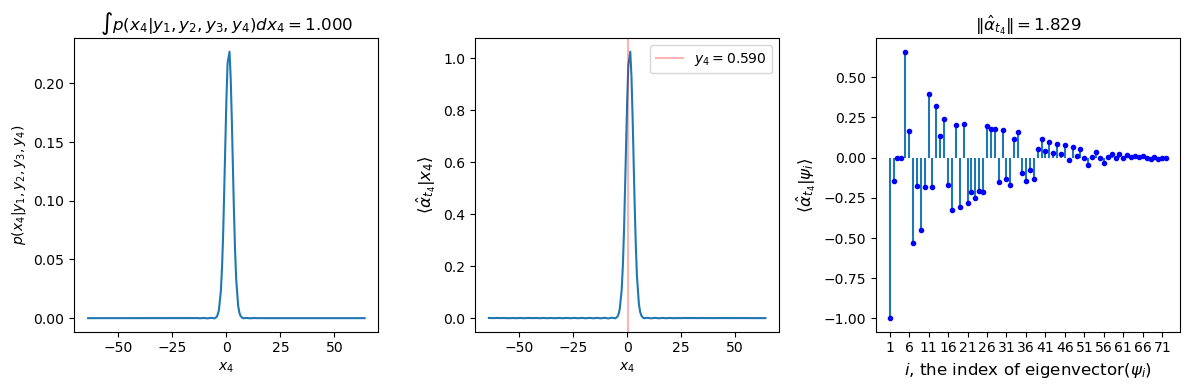

In [269]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_alpha4_hat)
ax.set_ylabel("\$p(x_4|y_1,y_2,y_3,y_4)\$")
ax.set_xlabel("\$x_4\$")
title = @sprintf "\$ \\int p(x_4|y_1,y_2,y_3,y_4)dx_4=%.3f \$" sum(w0 .* p_alpha4_hat)
ax.set_title(title)

ax = axes[2]
ax.plot(xref, alpha_t4_hat_x)
label = @sprintf "\$y_{%d}=%.3f\$" alpha_idx y
ax.axvline(y, color="red", alpha=0.3, label=label)
ax.set_xlabel("\$x_4\$")
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_4} |x_4 \\rangle\$", fontsize=12)
ax.legend()

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t4_hat, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t4_hat)
ax.set_xticks(xticks)c
ax.set_ylabel("\$\\langle \\hat{\\alpha}_{t_4} |\\psi_i \\rangle\$", fontsize=12)
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)", fontsize=12)
title = @sprintf "\$  \\Vert \\hat{\\alpha}_{t_4}  \\Vert =%.3f \$" alpha_t4_hat_norm
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/alpha_t4_hat.pdf")
plt.show()